In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/final

/content/gdrive/My Drive/final


In [ ]:
#--------------------------------------------------------
# Load images
#--------------------------------------------------------

In [4]:
import pandas as pd
from os import listdir
import os
from os.path import join
import cv2
import numpy as np

# Image directories path
path_train_0 = '/content/gdrive/My Drive/final/train_img/0/'
path_train_1 = '/content/gdrive/My Drive/final/train_img/1/'
path_valid_0 = '/content/gdrive/My Drive/final/valid_img/0/'
path_valid_1 = '/content/gdrive/My Drive/final/valid_img/1/'
files_train_0 = listdir(path_train_0) 
files_train_1 = listdir(path_train_1) 
files_valid_0 = listdir(path_valid_0)
files_valid_1 = listdir(path_valid_1)
X_train_0 = []
X_train_1 = []
X_valid_0 = []
X_valid_1 = []

# Load training images from Google drive directories
for i in np.linspace(0,2152,2153):
    path_train = os.path.join(path_train_0, files_train_0[int(i)])
    data = cv2.imread(path_train)
    data = cv2.resize(data, (150, 150), interpolation = cv2.INTER_AREA)
    X_train_0.append([data])

for i in np.linspace(0,1856,1857):
    path_train = os.path.join(path_train_1, files_train_1[int(i)])
    data = cv2.imread(path_train)
    data = cv2.resize(data, (150, 150), interpolation = cv2.INTER_AREA)
    X_train_1.append([data])

# Load valid images from Google drive directories
for i in np.linspace(0,560,561):
    path_valid = os.path.join(path_valid_0, files_valid_0[int(i)])
    data = cv2.imread(path_valid)
    data = cv2.resize(data, (150, 150), interpolation = cv2.INTER_AREA)
    X_valid_0.append([data])

for i in np.linspace(0,444,445):
    path_valid = os.path.join(path_valid_1, files_valid_1[int(i)])
    data = cv2.imread(path_valid)
    data = cv2.resize(data, (150, 150), interpolation = cv2.INTER_AREA)
    X_valid_1.append([data])

# Merge training images
X_train = []
X_train[:2153] = X_train_0
X_train[2153:4010] = X_train_1
X_train = np.array(X_train).reshape(4010,150,150,3)

# Merge valid images
X_valid = []
X_valid[:561] = X_valid_0
X_valid[561:1006] = X_valid_1
X_valid = np.array(X_valid).reshape(1006,150,150,3)

In [5]:
X_train.shape

(4010, 150, 150, 3)

In [6]:
import numpy as np

# Trainging labels
Y_train_0 = np.zeros(2153)[:,np.newaxis]
Y_train_1 = np.ones(1857)[:,np.newaxis]
Y_train = np.vstack((Y_train_0, Y_train_1))
Y_train = Y_train.reshape(4010)

# Valid labels
Y_valid_0 = np.zeros(561)[:,np.newaxis]
Y_valid_1 = np.ones(445)[:,np.newaxis]
Y_valid = np.vstack((Y_valid_0, Y_valid_1 ))
Y_valid = Y_valid.reshape(1006)

In [ ]:
#-----------------------------------------------------
# Pretrained model - VGG16、InceptionResNetV2、xception
#-----------------------------------------------------

In [7]:
import keras
from keras.applications import VGG16, inception_resnet_v2, xception

VGG_base = VGG16(weights='imagenet',
          include_top=False,
          input_shape=(150, 150, 3))

resnet_base = inception_resnet_v2.InceptionResNetV2(weights='imagenet',
                           include_top=False,
                           input_shape=(150, 150, 3))

xception_base = xception.Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

83689472/83683744 [==============================] - 2s 0us/step


In [17]:
resnet_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_207 (BatchN (None, 74, 74, 32)   96          conv2d_207[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 74, 74, 32)   0           batch_normalization_207[0][0]    
________________________________________________________________________________

In [ ]:
#-----------------------------------------------------
# Data augmentation
#-----------------------------------------------------

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                   rotation_range=30,
                   width_shift_range=0.2,
                   height_shift_range=0.2,
                   shear_range=0.2,
                   zoom_range=0.2)

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 10

def extract_features_train(X_train, Y_train, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 1536))
    labels = np.zeros(shape=(sample_count))
    generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = resnet_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

def extract_features_valid(X_train, Y_train, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 1536))
    labels = np.zeros(shape=(sample_count))
    generator = valid_datagen.flow(X_train, Y_train, batch_size=batch_size)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = resnet_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels   

train_features, train_labels = extract_features_train(X_train, Y_train, 5000)
validation_features, validation_labels = extract_features_valid(X_valid, Y_valid, 1000)

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras import regularizers

train_features = np.reshape(train_features, (5000, 3 * 3 * 1536))
validation_features = np.reshape(validation_features, (1000, 3 * 3 * 1536))

# Build top layers
model = models.Sequential()
model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_dim=3 * 3 * 1536))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
       loss='binary_crossentropy',
       metrics=['acc'])

history = model.fit(train_features, train_labels,
           epochs=35,
           batch_size=20,
           validation_data=(validation_features, validation_labels))

Epoch 1/35
250/250 [==============================] - 1s 5ms/step - loss: 1.8964 - acc: 0.6200 - val_loss: 0.8919 - val_acc: 0.7040
Epoch 2/35
250/250 [==============================] - 1s 4ms/step - loss: 1.2793 - acc: 0.6492 - val_loss: 1.5408 - val_acc: 0.5650
Epoch 3/35
250/250 [==============================] - 1s 4ms/step - loss: 1.1571 - acc: 0.6620 - val_loss: 0.6732 - val_acc: 0.7090
Epoch 4/35
250/250 [==============================] - 1s 4ms/step - loss: 1.2055 - acc: 0.6836 - val_loss: 0.7095 - val_acc: 0.7650
Epoch 5/35
250/250 [==============================] - 1s 4ms/step - loss: 1.0173 - acc: 0.7006 - val_loss: 0.6282 - val_acc: 0.7820
Epoch 6/35
250/250 [==============================] - 1s 4ms/step - loss: 0.9955 - acc: 0.6962 - val_loss: 0.7147 - val_acc: 0.7170
Epoch 7/35
250/250 [==============================] - 1s 4ms/step - loss: 0.9773 - acc: 0.7154 - val_loss: 0.8621 - val_acc: 0.7420
Epoch 8/35
250/250 [==============================] - 1s 4ms/step - loss: 0.

In [ ]:
#-----------------------------------------------------
# Plot result
#-----------------------------------------------------

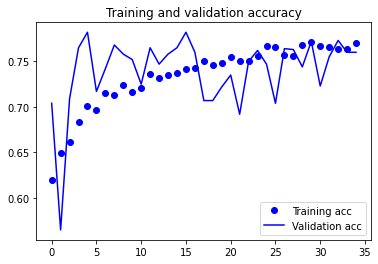

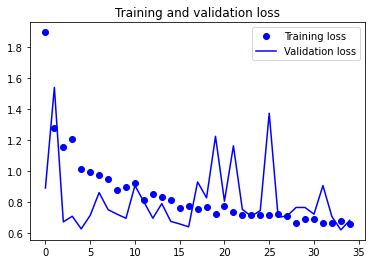

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#-----------------------------------------------------
# Predict
#-----------------------------------------------------

In [ ]:
from os import listdir
import os
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import cv2

# Load test images from Google drive directories
path_test = '/content/gdrive/My Drive/final/test_img'
files_test = listdir(path_test)
X_test = []

for i in np.linspace(0,912,913):
    full_path = os.path.join(path_test,files_test[int(i)])
    data = cv2.imread(full_path)
    data = cv2.resize(data, (150, 150), interpolation = cv2.INTER_AREA)
    X_test.append([data])

X_test = np.array(X_test).reshape(913,150,150,3)
X_test = X_test.astype('float32') / 255

# Predict 
output = resnet_base.predict(X_test)
output = np.reshape(output, (913, 3 * 3 * 1536))
Y_predict = model.predict_classes(output)

# Convert Y_predict to csv data
Y_pred = Y_pred.reshape(913)
name = [0] * 913
for i in np.linspace(0,912,913):
    i = int(i)
    name[i]='{:d}.png'.format(int(i)).zfill(7)
    
y_pred2 = { "image": name, "label": Y_pred}  
y_pred3 = pd.DataFrame(y_pred2)
y_pred3.to_csv('/content/gdrive/My Drive/final/Y_predict_resnet.csv', index = False)

In [ ]:
#-----------------------------------------------------
# Ensenble
#-----------------------------------------------------

In [ ]:
# Load InceptionResNetV2 output
train_1 = pd.read_csv('C:/Users/USER/Desktop/final/Y_pred_resnet.csv')
label_1 = train_1['label']

# Load VGG16 output
train_2 = pd.read_csv('C:/Users/USER/Desktop/final/Y_pred_VGG.csv')
label_2 = train_2['label']

# Load xception output
train_3 = pd.read_csv('C:/Users/USER/Desktop/final/Y_pred_xception.csv')
label_3 = train_3['label']

Y_pred_en=[0]*913

# Ensenble
for i in np.linspace(0,912,913):
    i = int(i)
    vote = 0
    if label_1[i] == 1:
        vote += 1
    if label_2[i] == 1:
        vote += 1
    if label_3[i] == 1:
        vote += 1
    if vote >= 2:
        Y_pred_en[i] = 1
    else:
        Y_pred_en[i] = 0